In [1]:
# Import Dependencies
import gym
import numpy as np
import matplotlib.pyplot as plt
import torch as T
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [2]:
# Linear DQN Network
class LinearDeepQNetwork(nn.Module):
    def __init__(self, lr, n_actions, input_dims):
        super(LinearDeepQNetwork, self).__init__()

        self.fc1 = nn.Linear(*input_dims, 128)
        self.fc2 = nn.Linear(128, n_actions)

        self.optimizer = optim.Adam(self.parameters(), lr=lr)
        self.loss = nn.MSELoss()
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state):
        layer1 = F.relu(self.fc1(state))
        actions = self.fc2(layer1)

        return actions

In [3]:
# Function to Plot Model Progress
def plot_learning_curve(x, scores, epsilon_history, filename):
    fig = plt.figure()
    ax1 = fig.add_subplot(111, label='1')
    ax2 = fig.add_subplot(111, label='2', frame_on=False)
    
    ax1.plot(x, epsilon_history, color='C0')
    ax1.set_xlabel('Training Steps', color='C0')
    ax1.set_ylabel('Epsilon', color='C0')
    ax1.tick_params(axis='x', colors='C0')
    ax1.tick_params(axis='y', colors='C0')
    
    N = len(scores)
    running_avg = np.empty(N)
    for t in range(N):
        running_avg[t] = np.mean(scores[max(0, t-100):(t+1)])
    
    ax2.scatter(x, running_avg, color='C1')
    ax2.axes.get_xaxis().set_visible(False)
    ax2.yaxis.tick_right()
    ax2.set_ylabel('Score', color='C1')
    ax2.yaxis.set_label_position('right')
    ax2.tick_params(axis='y', colors='C1')
    
    plt.savefig(filename)
    plt.show()

episode  0 score 25.0 avg score 25.0 epsilon 1.00
episode  100 score 40.0 avg score 22.5 epsilon 0.98
episode  200 score 14.0 avg score 21.8 epsilon 0.96
episode  300 score 11.0 avg score 22.7 epsilon 0.93
episode  400 score 17.0 avg score 21.4 epsilon 0.91
episode  500 score 23.0 avg score 24.1 epsilon 0.89
episode  600 score 12.0 avg score 25.5 epsilon 0.86
episode  700 score 39.0 avg score 23.3 epsilon 0.84
episode  800 score 19.0 avg score 23.0 epsilon 0.82
episode  900 score 18.0 avg score 24.6 epsilon 0.79
episode  1000 score 10.0 avg score 22.4 epsilon 0.77
episode  1100 score 39.0 avg score 21.8 epsilon 0.75
episode  1200 score 20.0 avg score 22.6 epsilon 0.72
episode  1300 score 26.0 avg score 23.4 epsilon 0.70
episode  1400 score 15.0 avg score 25.4 epsilon 0.68
episode  1500 score 17.0 avg score 25.2 epsilon 0.65
episode  1600 score 44.0 avg score 26.7 epsilon 0.62
episode  1700 score 16.0 avg score 28.5 epsilon 0.59
episode  1800 score 25.0 avg score 33.9 epsilon 0.56
episo

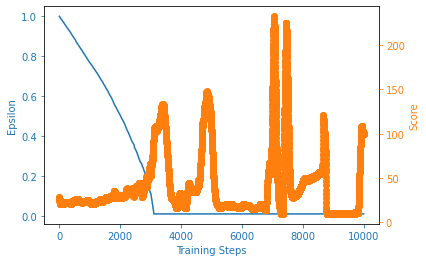

In [4]:
# Agent Class
class Agent():
    def __init__(self, input_dims, n_actions, lr, gamma=0.99,
                 epsilon=1.0, eps_dec=1e-5, eps_min=0.01):
        self.lr = lr
        self.input_dims = input_dims
        self.n_actions = n_actions
        self.gamma = gamma
        self.epsilon = epsilon
        self.eps_dec = eps_dec
        self.eps_min = eps_min
        self.action_space = [i for i in range(self.n_actions)]

        self.Q = LinearDeepQNetwork(self.lr, self.n_actions, self.input_dims)

    def choose_action(self, observation):
        if np.random.random() > self.epsilon:
            state = T.tensor(observation, dtype=T.float).to(self.Q.device)
            actions = self.Q.forward(state)
            action = T.argmax(actions).item()
        else:
            action = np.random.choice(self.action_space)

        return action

    def decrement_epsilon(self):
        self.epsilon = self.epsilon - self.eps_dec \
                        if self.epsilon > self.eps_min else self.eps_min

    def learn(self, state, action, reward, state_):
        self.Q.optimizer.zero_grad()
        states = T.tensor(state, dtype=T.float).to(self.Q.device)
        actions = T.tensor(action).to(self.Q.device)
        rewards = T.tensor(reward).to(self.Q.device)
        states_ = T.tensor(state_, dtype=T.float).to(self.Q.device)

        q_pred = self.Q.forward(states)[actions]

        q_next = self.Q.forward(states_).max()

        q_target = reward + self.gamma*q_next

        loss = self.Q.loss(q_target, q_pred).to(self.Q.device)
        loss.backward()
        self.Q.optimizer.step()
        self.decrement_epsilon()

if __name__ == '__main__':
    env = gym.make('CartPole-v1')
    n_games = 10000
    scores = []
    eps_history = []

    agent = Agent(lr=0.0001, input_dims=env.observation_space.shape,
                  n_actions=env.action_space.n)

    for i in range(n_games):
        score = 0
        done = False
        obs = env.reset()

        while not done:
            action = agent.choose_action(obs)
            obs_, reward, done, info = env.step(action)
            score += reward
            agent.learn(obs, action, reward, obs_)
            obs = obs_
        scores.append(score)
        eps_history.append(agent.epsilon)

        if i % 100 == 0:
            avg_score = np.mean(scores[-100:])
            print('episode ', i, 'score %.1f avg score %.1f epsilon %.2f' %
                  (score, avg_score, agent.epsilon))
    filename = 'cartpole_naive_dqn.png'
    x = [i+1 for i in range(n_games)]
    plot_learning_curve(x, scores, eps_history, filename)